In [ ]:
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
pd.set_option("display.max_columns", 50)
sys.path.insert(0,'/home/oem/Projects/Kylearn')
from Models.Mean_Teacher.mean_teacher_dataset import Mean_Teacher_dataset

In [2]:
# Restore model
number = 2300
sess = tf.Session()
saver = tf.train.import_meta_graph('models/attn-%s.meta'%str(number))
saver.restore(sess=sess, save_path='models/attn-%s'%str(number))
graph = tf.get_default_graph()

INFO:tensorflow:Restoring parameters from models/attn-2300


In [3]:
# Get tensors
input_x = graph.get_tensor_by_name('input/features:0')
input_dev = graph.get_tensor_by_name('input/dev_type:0')
is_training = graph.get_tensor_by_name('input/is_training:0')
output_proba = graph.get_tensor_by_name('error/Sigmoid:0')
attention_matrix = graph.get_tensor_by_name('scaling_attention/Relu:0') 
attention_matrix_output = graph.get_tensor_by_name('bias_attention/Relu:0')

In [4]:
# load dataset or just load npy file
dataset = Attn_dataset_1d(feature_path='data/X',
                       dev_path= 'data/dev',
                       label_path='data/y',
                       out_num=12)

In [5]:
# Output probability
proba = sess.run(output_proba, feed_dict={input_x: dataset.test_set['x'],
                                           input_dev: dataset.test_set['dev'],
                                           is_training: False})

In [7]:
# difine lists
alarm_list = ['Excessive Error Ratio', 'Frequency Out Of Range', 'GCC0 Link Failure',
              'Gauge Threshold Crossing Alert Summary', 'Link Down', 'Local Fault',
              'Loss Of Clock', 'Loss Of Frame', 'Loss Of Signal', 'OSC OSPF Adjacency Loss',
              'OTU Signal Degrade', 'Rx Power Out Of Range']
dev_list = ['AMP', 'ETH10G', 'ETHN', 'ETTP', 'OC192', 'OPTMON', 'OSC', 'OTM', 'OTM2', 'OTUTTP', 'PTP']

pm_list = ['BBE-RS',
            'CV-OTU', 'CV-S',
            'DROPGAINAVG-OTS', 'DROPGAINMAX-OTS_DROPGAINMIN-OTS_-',
            'E-CV', 'E-ES', 'E-INFRAMESERR_E-INFRAMES_/', 'E-OUTFRAMESERR_E-OUTFRAMES_/',
            'E-UAS', 'ES-OTU', 'ES-RS', 'ES-S',
            'OCH-OPRAVG', 'OCH-OPRMAX_OCH-OPRMIN_-', 'OCH-SPANLOSSAVG', 'OCH-SPANLOSSMAX_OCH-SPANLOSSMIN_-',
            'OPINAVG-OTS', 'OPINMAX-OTS_OPINMIN-OTS_-',
            'OPOUTAVG-OTS', 'OPOUTAVG-OTS_OPINAVG-OTS_-', 'OPOUTMAX-OTS_OPOUTMIN-OTS_-',
            'OPRAVG-OCH', 'OPRAVG-OTS', 'OPRMAX-OCH_OPRMIN-OCH_-', 'OPRMAX-OTS_OPRMIN-OTS_-',
            'OPTAVG-OCH', 'OPTAVG-OTS', 'OPTMAX-OCH_OPTMIN-OCH_-', 'OPTMAX-OTS_OPTMIN-OTS_-',
            'ORLAVG-OTS', 'ORLMIN-OTS', 'OTU-CV', 'OTU-ES', 'OTU-QAVG', 'OTU-QSTDEV',
            'PCS-CV', 'PCS-ES', 'PCS-UAS',
            'QAVG-OTU', 'QSTDEV-OTU',
            'RS-BBE', 'RS-ES',
            'S-CV', 'S-ES']

              precision    recall  f1-score   support

           0       0.75      0.09      0.17        96
           1       1.00      0.99      1.00       277
           2       0.34      0.96      0.50        24
           3       0.88      0.78      0.82         9
           4       0.87      1.00      0.93        13
           5       0.64      0.97      0.77       566
           6       0.75      0.12      0.20        26
           7       0.62      0.09      0.15       244
           8       0.75      0.76      0.76       127
           9       1.00      0.96      0.98        24
          10       0.00      0.00      0.00        14
          11       0.86      0.86      0.86        49

   micro avg       0.72      0.72      0.72      1469
   macro avg       0.70      0.63      0.59      1469
weighted avg       0.73      0.72      0.66      1469



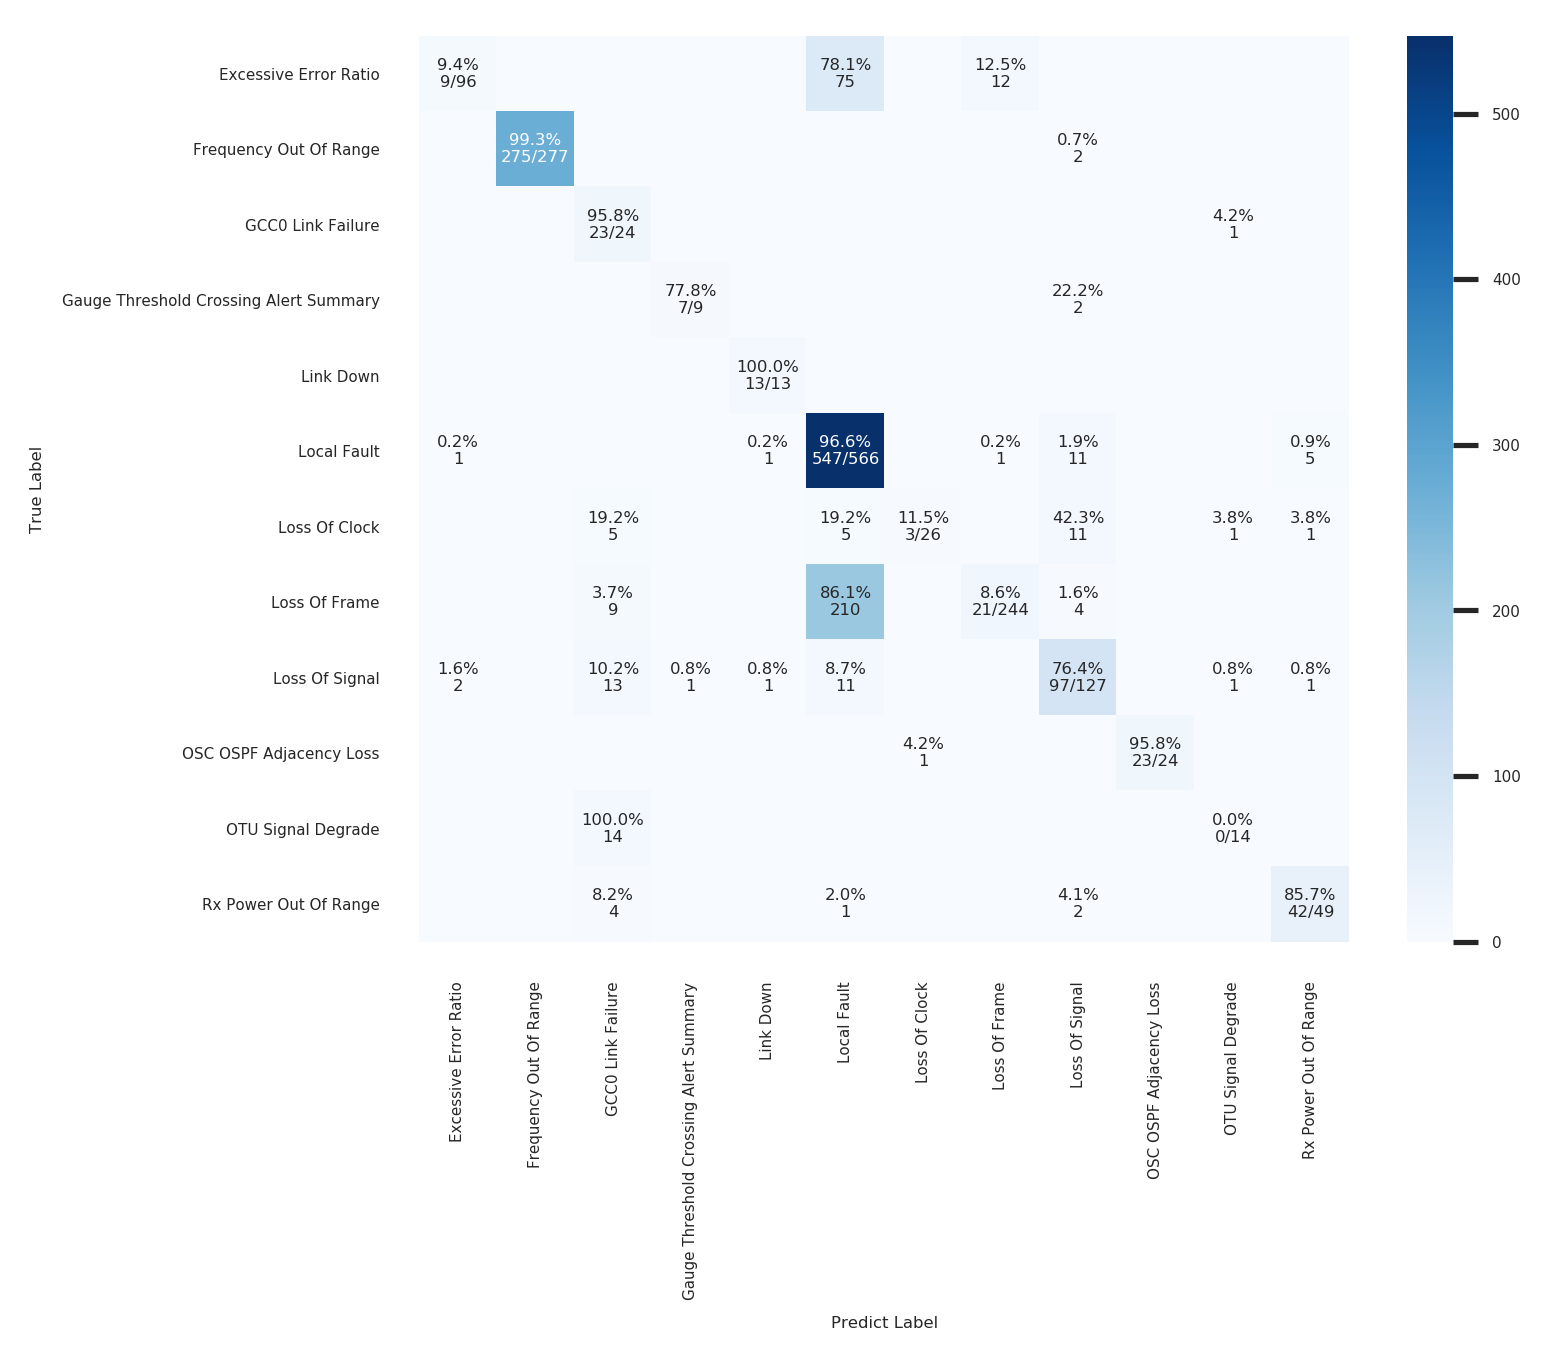

In [8]:
import matplotlib.pyplot as pyplot
import numpy as np
import pandas as pd
import seaborn as sb
import math
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report

pyplot.rcParams['savefig.dpi'] = 300  # pixel
pyplot.rcParams['figure.dpi'] = 300  # resolution
pyplot.rcParams["figure.figsize"] = [5,4] # figure size

# plot function
def draw_confusion_matrix(cm, labels, plt = pyplot, x_rotation=90, y_rotation=0, font_size=0.33, precision=False):


    if (precision):
        '''flip and rotate the confusion metrix'''
        labels = labels[::-1]
        cm = np.rot90(np.flip(cm, axis=0))

    cm_sum = np.sum(cm, axis=1, keepdims=True)

    cm_perc = cm / cm_sum.astype(float) * 100

    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif (c == 0):
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)

    if (precision):
        cm.columns.name = 'True Label'
        cm.index.name = 'Predict Label'
    else:
        cm.index.name = 'True Label'
        cm.columns.name = 'Predict Label'

    sb.set(font_scale=font_size)

    sb.heatmap(cm, annot=annot, fmt='', cmap='Blues')
    plt.xticks(rotation=x_rotation)
    plt.yticks(rotation=y_rotation)

    plt.show()

# get confusion matrix and accuracy, plot classification report
def metrics_multi(y_pred, y_test, labels):
    cm = confusion_matrix(np.array(y_test).flatten(), np.array(y_pred).flatten())
    print(classification_report(np.array(y_test).flatten(), np.array(y_pred).flatten()))
    acc = accuracy_score(y_test, y_pred)
    return cm, acc
# turn one-hot back to number label
prediction = np.argmax(proba, axis=1)
cm, accuracy = metrics_multi(
    y_pred=prediction, y_test=np.argmax(dataset.test_set['y'], axis=1), labels=alarm_list)

draw_confusion_matrix(cm, alarm_list, precision=False, plt=pyplot)

In [9]:
# probability of Excessive Error Ratio
proba_i = proba[:, 0]
real_i = dataset.test_set['y'][:, 0]

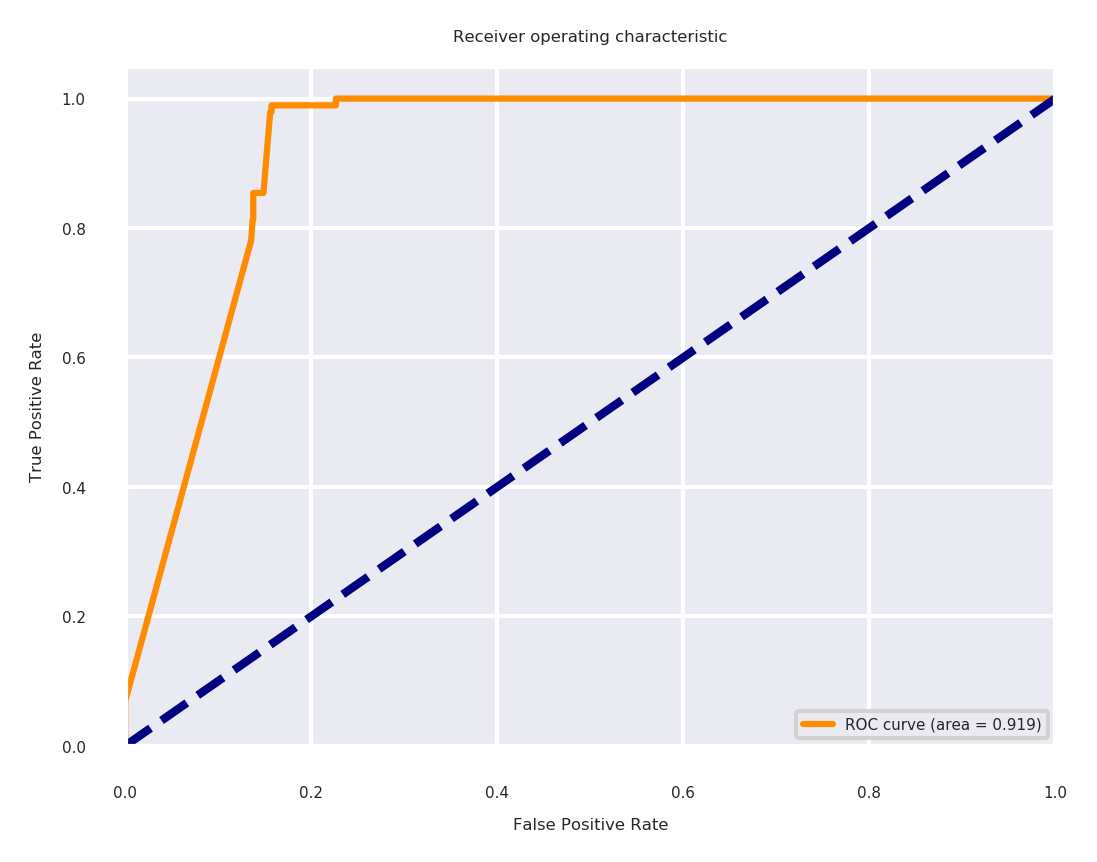

In [10]:
# Draw ROC for Excessive Error Ratio
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve

def auc_roc(y_pred, y_test):
    auc = roc_auc_score(y_true=y_test, y_score=y_pred)
    fprs, tprs, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    return auc, fprs, tprs, thresholds

import matplotlib.pyplot as pyplot
pyplot.rcParams['savefig.dpi'] = 300  # pixel
pyplot.rcParams['figure.dpi'] = 300  # resolution
pyplot.rcParams["figure.figsize"] = [4,3] # figure size

def plot_roc_curve(fprs, tprs, auc, x_axis = 1, plt = pyplot):

    plt.plot(fprs, tprs, color="darkorange", label='ROC curve (area = %0.3f)' % auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, x_axis])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
# calculate auc, false positive rates and etc.
auc, fprs, tprs, thresholds = auc_roc(y_pred=proba_i, y_test=real_i)

# plot roc curve
plot_roc_curve(fprs, tprs, auc, x_axis=1)

In [11]:
# get metrics for binary classification
def metrics_binary(y_pred, threshold, y_test):
    y_pred_copy = y_pred.copy()
    y_pred_copy[y_pred_copy >= threshold] = 1
    y_pred_copy[y_pred_copy < threshold] = 0
    cm = confusion_matrix(y_test, y_pred_copy)
    tp = cm[1, 1]
    tn = cm[0, 0]
    fp = cm[0, 1]
    fn = cm[1, 0]
    fpr = fp / (fp + tn)
    accuracy = (tp + tn) / (np.sum(cm))
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    print('accuracy: ' + str(accuracy) + '\n')
    print('precision: ' + str(precision) + '\n')
    print('recall: ' + str(recall) + '\n')
    print('false positive rate: ' + str(fpr) + '\n')
    return cm, fpr, accuracy, precision, recall

accuracy: 0.8590878148400273

precision: 0.29213483146067415

recall: 0.8125

false positive rate: 0.13765477057538236



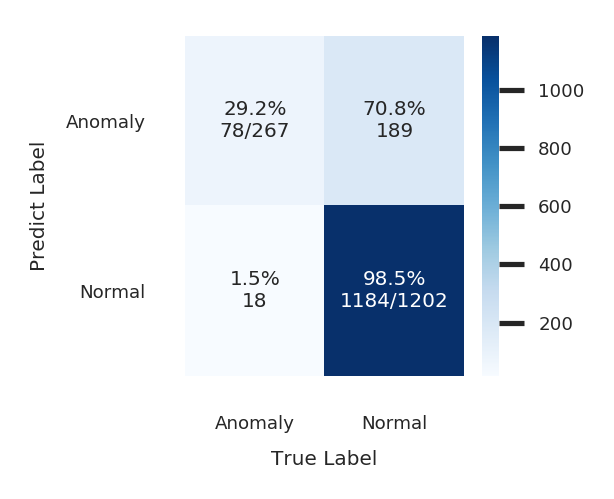

In [12]:
# move threshold from 0.9 to 0.9999 to see the change of fpr, acc and etc.
threshold = 0.99
cm, fpr, acc, precision, recall = metrics_binary(
    y_pred=proba_i, y_test=real_i,threshold=threshold)

import matplotlib.pyplot as plt
plt.rcParams['savefig.dpi'] = 300  # pixel
plt.rcParams['figure.dpi'] = 300  # resolution
plt.rcParams["figure.figsize"] = [1.5,1.5] # figure size
# draw cm
draw_confusion_matrix(cm, ['Normal', 'Anomaly'],
                      plt = plt, precision=True, 
                      font_size = 0.4, x_rotation = 0)

## Visualize attention layer

In [14]:
def visualize_input_attention(matrix, dev_list, pm_list):
    attn_matrix = pd.DataFrame(data=matrix, index=dev_list, columns=pm_list)
    attn_matrix[attn_matrix == 1] = 0
    return attn_matrix

def visualize_output_attention(matrix, dev_list, alarm_list):
    attn_matrix = pd.DataFrame(data=matrix, index=dev_list, columns=alarm_list)
    return attn_matrix

In [15]:
# diagonal matrix of 11-dim representing 11 device types
test_dev = np.diag(np.ones([11]))
test_dev

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [16]:
# output attentions, attn_matrix_input is the input attention and attn_matrix_output is the output attention
attn_matrix_input, attn_matrix_output = sess.run([attention_matrix, attention_matrix_output], feed_dict={input_dev: test_dev})

In [17]:
attn_matrix_input = visualize_input_attention(attn_matrix_input, dev_list, pm_list)

In [18]:
attn_matrix_input

,BBE-RS,CV-OTU,CV-S,DROPGAINAVG-OTS,DROPGAINMAX-OTS_DROPGAINMIN-OTS_-,E-CV,E-ES,E-INFRAMESERR_E-INFRAMES_/,E-OUTFRAMESERR_E-OUTFRAMES_/,E-UAS,ES-OTU,ES-RS,ES-S,OCH-OPRAVG,OCH-OPRMAX_OCH-OPRMIN_-,OCH-SPANLOSSAVG,OCH-SPANLOSSMAX_OCH-SPANLOSSMIN_-,OPINAVG-OTS,OPINMAX-OTS_OPINMIN-OTS_-,OPOUTAVG-OTS,OPOUTAVG-OTS_OPINAVG-OTS_-,OPOUTMAX-OTS_OPOUTMIN-OTS_-,OPRAVG-OCH,OPRAVG-OTS,OPRMAX-OCH_OPRMIN-OCH_-,OPRMAX-OTS_OPRMIN-OTS_-,OPTAVG-OCH,OPTAVG-OTS,OPTMAX-OCH_OPTMIN-OCH_-,OPTMAX-OTS_OPTMIN-OTS_-,ORLAVG-OTS,ORLMIN-OTS,OTU-CV,OTU-ES,OTU-QAVG,OTU-QSTDEV,PCS-CV,PCS-ES,PCS-UAS,QAVG-OTU,QSTDEV-OTU,RS-BBE,RS-ES,S-CV,S-ES
AMP,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,1.008995,0.969836,1.027609,1.028857,1.024032,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.976977,0.988123,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
ETH10G,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
ETHN,0.0,0.0,0.0,0.0,0.0,0.0,0.984484,1.223385,0.0,1.072858,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.188157,1.403503,0.891689,0.0,0.0,0.0,0.0,0.0,0.0
ETTP,0.0,0.0,0.0,0.0,0.0,0.0,1.103037,1.064395,0.0,1.297827,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.885848,0.940549,0.912246,0.0,0.0,0.0,0.0,0.0,0.0
OC192,0.0,0.0,0.0,0.0,0.0,0.0,1.308199,0.882269,0.0,0.806598,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.959606,1.118284,0.0,0.0,0.0,0.0,0.0,0.0
OPTMON,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.98057,0.000000,0.855423,0.0,1.114726,0.0,1.208922,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
OSC,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.12831,1.074277,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
OTM,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.959963,0.00000,0.937534,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,1.081404,0.961981,1.029866,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
OTM2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,1.132520,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
OTUTTP,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,1.065954,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
attn_matrix_output = visualize_output_attention(attn_matrix_output, dev_list, alarm_list)

In [20]:
attn_matrix_output

,Excessive Error Ratio,Frequency Out Of Range,GCC0 Link Failure,Gauge Threshold Crossing Alert Summary,Link Down,Local Fault,Loss Of Clock,Loss Of Frame,Loss Of Signal,OSC OSPF Adjacency Loss,OTU Signal Degrade,Rx Power Out Of Range
AMP,0.282624,0.018717,0.000000,0.262012,0.000000,0.147246,0.0,0.000000,0.000000,0.349123,0.000000,0.000000
ETH10G,0.000000,0.000000,0.333001,0.000000,0.349009,0.000000,0.0,0.000000,0.255547,0.632078,0.000000,0.266769
ETHN,0.342729,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.652261,1.531970,0.786505,0.000000,0.204058
ETTP,0.000000,0.000000,0.000000,0.153151,0.000000,0.000000,0.0,0.000000,0.000000,0.060214,0.007426,0.000000
OC192,0.489065,0.000000,0.144511,0.074497,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.262907,0.000000
OPTMON,0.341570,0.000000,0.000000,0.741800,0.000000,0.000000,0.0,0.193246,0.381933,0.000000,0.000000,0.000000
OSC,0.283152,0.000000,0.248986,0.556665,0.335805,0.000000,0.0,0.000000,0.000000,0.807169,0.019798,0.000000
OTM,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.419170,0.499557,0.000000,0.000000
OTM2,0.377772,0.277645,0.141339,0.000000,0.000000,0.000000,0.0,0.564895,0.596956,0.000000,0.000000,0.000000
OTUTTP,0.016973,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.287204,0.005432,0.000000,0.000000
